In [3]:
!pip install numpy

'pip' n�o � reconhecido como um comando interno
ou externo, um programa oper�vel ou um arquivo em lotes.


In [22]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
# started at https://www.kaggle.com/renataghisloti
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
from copy import deepcopy
import warnings
warnings.filterwarnings("ignore")
import random
import os
random.seed(42)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
isInKaggle=False
DATA_ROOT = "/kaggle/input/parkinson/" if isInKaggle else "../data/parkinson/"
RESULTS_ROOT = "/kaggle/working/" if isInKaggle else "../results/parkinson/"
# Input train files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

for dirname, _, filenames in os.walk(DATA_ROOT):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

../data/parkinson/MDS-UPDRS_English_FINAL.pdf
../data/parkinson/public_timeseries_testing_util.py
../data/parkinson/supplemental_clinical_data.csv
../data/parkinson/train_clinical_data.csv
../data/parkinson/train_peptides.csv
../data/parkinson/train_proteins.csv
../data/parkinson/variablesDescription.txt
../data/parkinson/amp_pd_peptide\competition.cpython-37m-x86_64-linux-gnu.so
../data/parkinson/amp_pd_peptide\__init__.py
../data/parkinson/example_test_files\sample_submission.csv
../data/parkinson/example_test_files\test.csv
../data/parkinson/example_test_files\test_peptides.csv
../data/parkinson/example_test_files\test_proteins.csv


## Loading datasets

First of all, lets start loading the datasets

In [23]:
df_proteins = pd.read_csv(DATA_ROOT+'train_proteins.csv')
df_peptides = pd.read_csv(DATA_ROOT+'train_peptides.csv')
df_clinical = pd.read_csv(DATA_ROOT+'train_clinical_data.csv')

## Descriptive data analysis

Lets look more closer to the datasets and understand the data

In [24]:
#Seeing the datasets shape
print('df_proteins: ', df_proteins.shape)
print('df_peptides: ', df_peptides.shape)
print('df_clinical: ', df_clinical.shape)

df_proteins:  (232741, 5)
df_peptides:  (981834, 6)
df_clinical:  (2615, 8)


In [25]:
#Seeing the columns
print('df_proteins: ', df_proteins.columns)
print('df_peptides: ', df_peptides.columns)
print('df_clinical: ', df_clinical.columns)

df_proteins:  Index(['visit_id', 'visit_month', 'patient_id', 'UniProt', 'NPX'], dtype='object')
df_peptides:  Index(['visit_id', 'visit_month', 'patient_id', 'UniProt', 'Peptide',
       'PeptideAbundance'],
      dtype='object')
df_clinical:  Index(['visit_id', 'patient_id', 'visit_month', 'updrs_1', 'updrs_2',
       'updrs_3', 'updrs_4', 'upd23b_clinical_state_on_medication'],
      dtype='object')


We can see that the datasets have some shared columns (visit_id, visit_month, patient_id) that we could use to merge the data and also columns that are specific for each dataset. 

In [26]:
#Looking closer to the data info of each dataset
df_proteins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232741 entries, 0 to 232740
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   visit_id     232741 non-null  object 
 1   visit_month  232741 non-null  int64  
 2   patient_id   232741 non-null  int64  
 3   UniProt      232741 non-null  object 
 4   NPX          232741 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 8.9+ MB


In [27]:
df_peptides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981834 entries, 0 to 981833
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   visit_id          981834 non-null  object 
 1   visit_month       981834 non-null  int64  
 2   patient_id        981834 non-null  int64  
 3   UniProt           981834 non-null  object 
 4   Peptide           981834 non-null  object 
 5   PeptideAbundance  981834 non-null  float64
dtypes: float64(1), int64(2), object(3)
memory usage: 44.9+ MB


In [28]:
df_clinical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2615 entries, 0 to 2614
Data columns (total 8 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   visit_id                             2615 non-null   object 
 1   patient_id                           2615 non-null   int64  
 2   visit_month                          2615 non-null   int64  
 3   updrs_1                              2614 non-null   float64
 4   updrs_2                              2613 non-null   float64
 5   updrs_3                              2590 non-null   float64
 6   updrs_4                              1577 non-null   float64
 7   upd23b_clinical_state_on_medication  1288 non-null   object 
dtypes: float64(4), int64(2), object(2)
memory usage: 163.6+ KB


We can see that we will be handling a considerable amount of data (mainly in the peptides dataset). The corresponding columns in the three datasets have the same data types and the proteins and peptide datasets do not have null values. The clinical data dataset have some null values, mainly in the 'upd23b_clinical_state_on_medication'. In the next setps we will need to analyze if we will use all the columns and what we will do with null values if it is necessary to use the columns with nulls. 

In [29]:
print('maximal "df_clinical" number of visits: ', df_clinical.visit_month.nunique())
print('maximal "df_peptides" number of visits: ', df_peptides.visit_month.nunique())
print('maximal "df_proteins" number of visits: ', df_proteins.visit_month.nunique())

maximal "df_clinical" number of visits:  17
maximal "df_peptides" number of visits:  15
maximal "df_proteins" number of visits:  15


The ``visit_monhts`` from ``df_clinical`` has two months more than ``df_proteins`` and ``df_proteins`` (months 9, 42, )

In [30]:
#Let's take a look on the data
df_proteins

,visit_id,visit_month,patient_id,UniProt,NPX
0,55_0,0,55,O00391,11254.3
1,55_0,0,55,O00533,732430.0
2,55_0,0,55,O00584,39585.8
3,55_0,0,55,O14498,41526.9
4,55_0,0,55,O14773,31238.0
...,...,...,...,...,...
232736,58648_108,108,58648,Q9UBX5,27387.8
232737,58648_108,108,58648,Q9UHG2,369437.0
232738,58648_108,108,58648,Q9UKV8,105830.0
232739,58648_108,108,58648,Q9Y646,21257.6


In [31]:
df_peptides

,visit_id,visit_month,patient_id,UniProt,Peptide,PeptideAbundance
0,55_0,0,55,O00391,NEQEQPLGQWHLS,11254.30
1,55_0,0,55,O00533,GNPEPTFSWTK,102060.00
2,55_0,0,55,O00533,IEIPSSVQQVPTIIK,174185.00
3,55_0,0,55,O00533,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,27278.90
4,55_0,0,55,O00533,SMEQNGPGLEYR,30838.70
...,...,...,...,...,...,...
981829,58648_108,108,58648,Q9UHG2,ILAGSADSEGVAAPR,202820.00
981830,58648_108,108,58648,Q9UKV8,SGNIPAGTTVDTK,105830.00
981831,58648_108,108,58648,Q9Y646,LALLVDTVGPR,21257.60
981832,58648_108,108,58648,Q9Y6R7,AGC(UniMod_4)VAESTAVC(UniMod_4)R,5127.26


In [32]:
df_clinical

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN
1,55_3,55,3,10.0,7.0,25.0,NaN,NaN
2,55_6,55,6,8.0,10.0,34.0,NaN,NaN
3,55_9,55,9,8.0,9.0,30.0,0.0,On
4,55_12,55,12,10.0,10.0,41.0,0.0,On
...,...,...,...,...,...,...,...,...
2610,65043_48,65043,48,7.0,6.0,13.0,0.0,Off
2611,65043_54,65043,54,4.0,8.0,11.0,1.0,Off
2612,65043_60,65043,60,6.0,6.0,16.0,1.0,Off
2613,65043_72,65043,72,3.0,9.0,14.0,1.0,Off


## Pre-processing part 1

Lets merge the datasets

In [33]:
train = df_proteins.merge(df_peptides, on=['visit_id', 'visit_month', 'patient_id', 'UniProt'], how='left')
train = train.merge(df_clinical, on=['visit_id', 'visit_month', 'patient_id'], how='left')
train

,visit_id,visit_month,patient_id,UniProt,NPX,Peptide,PeptideAbundance,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,55_0,0,55,O00391,11254.3,NEQEQPLGQWHLS,11254.30,10.0,6.0,15.0,NaN,NaN
1,55_0,0,55,O00533,732430.0,GNPEPTFSWTK,102060.00,10.0,6.0,15.0,NaN,NaN
2,55_0,0,55,O00533,732430.0,IEIPSSVQQVPTIIK,174185.00,10.0,6.0,15.0,NaN,NaN
3,55_0,0,55,O00533,732430.0,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,27278.90,10.0,6.0,15.0,NaN,NaN
4,55_0,0,55,O00533,732430.0,SMEQNGPGLEYR,30838.70,10.0,6.0,15.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
981829,58648_108,108,58648,Q9UHG2,369437.0,ILAGSADSEGVAAPR,202820.00,6.0,0.0,0.0,NaN,NaN
981830,58648_108,108,58648,Q9UKV8,105830.0,SGNIPAGTTVDTK,105830.00,6.0,0.0,0.0,NaN,NaN
981831,58648_108,108,58648,Q9Y646,21257.6,LALLVDTVGPR,21257.60,6.0,0.0,0.0,NaN,NaN
981832,58648_108,108,58648,Q9Y6R7,17953.1,AGC(UniMod_4)VAESTAVC(UniMod_4)R,5127.26,6.0,0.0,0.0,NaN,NaN


## Exploratory train analysis

Now that we already know the data structure, let's extract some insights from it. 

### 1. How our quantitative features correlates with each other?

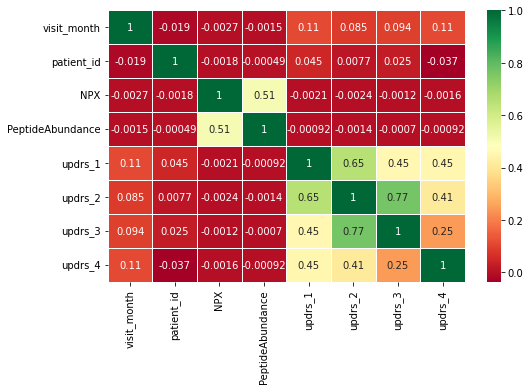

In [34]:
plt.figure(figsize=(8, 5));
color = 'RdYlGn';
sns.heatmap(train.corr(),annot=True, linewidth=.5, cmap=color);

It is possible to note that the updrs (patient's score for part N of the Unified Parkinson's Disease Rating Scale) correlates positively with each other, mainly the updrs_2 with the updrs_3. This makes sense because the updrs_2 score quantifies Motor Aspects of Experiences of Daily Living (M-EDL) and the updrs_3 quantifies the Motor Examination, and these aspects are closely related to each other (https://www.movementdisorders.org/MDS-Files1/PDFs/Rating-Scales/MDS-UPDRS_English_FINAL.pdf). There is no stron negative correlation between the features.

In [35]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 981834 entries, 0 to 981833
Data columns (total 12 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   visit_id                             981834 non-null  object 
 1   visit_month                          981834 non-null  int64  
 2   patient_id                           981834 non-null  int64  
 3   UniProt                              981834 non-null  object 
 4   NPX                                  981834 non-null  float64
 5   Peptide                              981834 non-null  object 
 6   PeptideAbundance                     981834 non-null  float64
 7   updrs_1                              941744 non-null  float64
 8   updrs_2                              941744 non-null  float64
 9   updrs_3                              932624 non-null  float64
 10  updrs_4                              495530 non-null  float64
 11  upd23b_clinic

### 2. What are the most and the least prevalent proteins among the patients in this dataset?

In [36]:
print('number of patients: ', train.patient_id.nunique())
print('maximal number of visits: ', train.visit_month.nunique())#in the original df_clinical there were 17 visits...
print('number of proteins: ', train.UniProt.nunique())
print('number of pepitides in the training set: ', train.Peptide.nunique())


number of patients:  248
maximal number of visits:  15
number of proteins:  227
number of pepitides in the training set:  968


In [37]:
#Most common
ppp = pd.DataFrame(df_proteins.groupby('UniProt').patient_id.nunique()).rename(columns={'patient_id':'count_patient'}).reset_index().sort_values('count_patient', ascending=False) #protein prevalence among patients
ppp

,UniProt,count_patient
95,P06727,248
102,P07858,248
176,Q06481,248
191,Q16270,248
97,P07225,248
...,...,...
194,Q6UX71,206
156,P36980,205
145,P23083,193
213,Q99829,187


The most common proteins appears in all patients in the dataset (248). The least common proteins apear in 185 patients (nearly 75% of the total of patients)

<AxesSubplot:ylabel='Count'>

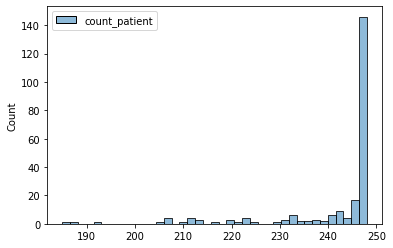

In [38]:
#Lets do a histogram to see how the protein expression frequency in the patients are distributed
sns.histplot(ppp)

Most of the proteins are present in at least 230 patients. The majority of tem (~140 proteins) are expressed in all the 248 patients

## Pre-processing part 2 - Handling with missing values
To check the stationarity of your variables, first we will need to handle with the missing values

In [39]:
#Verifying how much missing values we have in each column
train.isnull().sum()

visit_id                                    0
visit_month                                 0
patient_id                                  0
UniProt                                     0
NPX                                         0
Peptide                                     0
PeptideAbundance                            0
updrs_1                                 40090
updrs_2                                 40090
updrs_3                                 49210
updrs_4                                486304
upd23b_clinical_state_on_medication    590109
dtype: int64

# Regression
[Reference: Géron, Aurélien. Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow. O'Reilly Media. 2019](https://universidadefe957-my.sharepoint.com/:b:/g/personal/paulo_firmino_ufca_edu_br/Ec_UL4nCLQRGnFpftnOkv5ABrePEllnHLR7rrqPreAvn6A?e=RFGcMB)

In [40]:
train.columns

Index(['visit_id', 'visit_month', 'patient_id', 'UniProt', 'NPX', 'Peptide',
       'PeptideAbundance', 'updrs_1', 'updrs_2', 'updrs_3', 'updrs_4',
       'upd23b_clinical_state_on_medication'],
      dtype='object')

## Preprocessing

In [44]:
#variables types 
qualiVars = ['UniProt', 'Peptide']
quantiVars = ['visit_month', 'patient_id', 'NPX', 'PeptideAbundance']
targetVars = ['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']
y_train = train[targetVars]
quantiDf = train[quantiVars]
qualiDf = train[qualiVars]
# print(quantiDf.median().values)
print('###### quantiDf.describe \n', quantiDf.describe())
print('###### qualiDf.describe \n', qualiDf.describe())

###### quantiDf.describe 
          visit_month     patient_id           NPX  PeptideAbundance
count  981834.000000  981834.000000  9.818340e+05      9.818340e+05
mean       26.105061   32603.465361  1.699754e+07      6.428902e+05
std        22.913897   18605.934422  6.315432e+07      3.377989e+06
min         0.000000      55.000000  8.460820e+01      1.099850e+01
25%         6.000000   16566.000000  2.432580e+05      2.817425e+04
50%        24.000000   29313.000000  9.922740e+05      7.430830e+04
75%        48.000000   49995.000000  3.723542e+06      2.213388e+05
max       108.000000   65043.000000  6.138510e+08      1.787520e+08
###### qualiDf.describe 
        UniProt     Peptide
count   981834      981834
unique     227         968
top     P02787  TLLSNLEEAK
freq     51916        1113


### Imputation for quantitative variables

In [46]:
# Imputing missing data
from sklearn.impute import SimpleImputer 
print("*** before imputation ***")
print(quantiDf.describe())
imputer = SimpleImputer(strategy = "median", add_indicator = True)
imputer.fit(quantiDf)
print('medians: ', imputer.statistics_)
print('column index of features with missing values: ', imputer.indicator_.features_)
quantiDf = pd.DataFrame(imputer.transform(quantiDf), columns= imputer.get_feature_names_out())
print("\n *** after imputation ***")
# print(trash.median().values)
# print('indicator: ', imputer.indicator_)
print('features names: ', imputer.get_feature_names_out())
# print(trash.describe())
print(quantiDf.describe())
print(quantiDf.head())

*** before imputation ***
         visit_month     patient_id           NPX  PeptideAbundance
count  981834.000000  981834.000000  9.818340e+05      9.818340e+05
mean       26.105061   32603.465361  1.699754e+07      6.428902e+05
std        22.913897   18605.934422  6.315432e+07      3.377989e+06
min         0.000000      55.000000  8.460820e+01      1.099850e+01
25%         6.000000   16566.000000  2.432580e+05      2.817425e+04
50%        24.000000   29313.000000  9.922740e+05      7.430830e+04
75%        48.000000   49995.000000  3.723542e+06      2.213388e+05
max       108.000000   65043.000000  6.138510e+08      1.787520e+08
medians:  [2.40000e+01 2.93130e+04 9.92274e+05 7.43083e+04]
column index of features with missing values:  []

 *** after imputation ***
features names:  ['visit_month' 'patient_id' 'NPX' 'PeptideAbundance']
         visit_month     patient_id           NPX  PeptideAbundance
count  981834.000000  981834.000000  9.818340e+05      9.818340e+05
mean       26.1050

### Transformation for quantitative variables

In [47]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler() #MinMaxScaler(feature_range  = (.4, .6))
scaler.fit(quantiDf)
print('means: ', scaler.mean_)
print('stds: ', scaler.scale_)
quantiDf = pd.DataFrame(scaler.transform(quantiDf), columns= scaler.get_feature_names_out())
print(quantiDf.head())
# print(scaler.transform([[2, 2]]))

means:  [2.61050605e+01 3.26034654e+04 1.69975385e+07 6.42890246e+05]
stds:  [2.29138858e+01 1.86059249e+04 6.31542860e+07 3.37798737e+06]
   visit_month  patient_id       NPX  PeptideAbundance
0    -1.139268    -1.74936 -0.268965         -0.186986
1    -1.139268    -1.74936 -0.257546         -0.160104
2    -1.139268    -1.74936 -0.257546         -0.138753
3    -1.139268    -1.74936 -0.257546         -0.182242
4    -1.139268    -1.74936 -0.257546         -0.181188


### One-hot encoding for qualitative variables

In [48]:
from sklearn.preprocessing import OneHotEncoder
quali_encoder = OneHotEncoder() 
quali_encoder_1hot = quali_encoder.fit_transform(train[qualiVars])
# (quali_encoder_1hot)

In [51]:
# print('|||| quali_encoder_1hot.toarray(): \n', quali_encoder_1hot.toarray()[:3])
print('|||| quali_encoder.categories_: \n', quali_encoder.categories_)
print('|||| quali_encoder.get_feature_names_out(): \n', quali_encoder.get_feature_names_out())

|||| quali_encoder.categories_: 
 [array(['O00391', 'O00533', 'O00584', 'O14498', 'O14773', 'O14791',
       'O15240', 'O15394', 'O43505', 'O60888', 'O75144', 'O75326',
       'O94919', 'P00441', 'P00450', 'P00734', 'P00736', 'P00738',
       'P00746', 'P00747', 'P00748', 'P00751', 'P01008', 'P01009',
       'P01011', 'P01019', 'P01023', 'P01024', 'P01031', 'P01033',
       'P01034', 'P01042', 'P01344', 'P01591', 'P01594', 'P01608',
       'P01621', 'P01717', 'P01780', 'P01833', 'P01834', 'P01857',
       'P01859', 'P01860', 'P01861', 'P01876', 'P01877', 'P02452',
       'P02647', 'P02649', 'P02652', 'P02655', 'P02656', 'P02671',
       'P02675', 'P02679', 'P02747', 'P02748', 'P02749', 'P02750',
       'P02751', 'P02753', 'P02760', 'P02763', 'P02765', 'P02766',
       'P02768', 'P02774', 'P02787', 'P02790', 'P02792', 'P04004',
       'P04075', 'P04156', 'P04180', 'P04196', 'P04207', 'P04211',
       'P04216', 'P04217', 'P04275', 'P04406', 'P04433', 'P05060',
       'P05067', 'P05090', 

In [52]:
# quali_ohe_df = pd.DataFrame(quali_encoder_1hot)
# quali_ohe_df = pd.DataFrame(quali_encoder_1hot.toarray(), columns=quali_encoder.get_feature_names_out())
# quali_ohe_df.head(5)

MemoryError: Unable to allocate 8.74 GiB for an array with shape (981834, 1195) and data type float64

In [54]:
quali_encoder_1hot

<981834x1195 sparse matrix of type '<class 'numpy.float64'>'
	with 1963668 stored elements in Compressed Sparse Row format>

In [ ]:
trainOk = pd.concat([quantiDf, quali_ohe_df], axis=1)
trainOk.head()

,Fare,Age,Parch,SibSp,missingindicator_Age,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Embarked_nan
0,-0.502445,-0.565736,-0.473674,0.432793,-0.497895,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.786845,0.663861,-0.473674,0.432793,-0.497895,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,-0.488854,-0.258337,-0.473674,-0.474545,-0.497895,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.420730,0.433312,-0.473674,0.432793,-0.497895,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,-0.486337,0.433312,-0.473674,-0.474545,-0.497895,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


### Pipelines for aggregating everything

In [55]:
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import StandardScaler#, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer 
 
quantiPipeline = Pipeline([('imputer', SimpleImputer(strategy = "median", add_indicator = True)), 
                           ('std_scaler', StandardScaler())]) #MinMaxScaler(feature_range  = (.4, .6))
qualiPipeline = Pipeline([('ohe', OneHotEncoder(sparse = False)), 
                           ('std_scaler', StandardScaler())]) #MinMaxScaler(feature_range  = (.4, .6))

In [56]:
quantiOk = pd.DataFrame(quantiPipeline.fit_transform(quantiDf), columns=quantiPipeline.get_feature_names_out())
quantiOk.head()

,visit_month,patient_id,NPX,PeptideAbundance
0,-1.139268,-1.74936,-0.268965,-0.186986
1,-1.139268,-1.74936,-0.257546,-0.160104
2,-1.139268,-1.74936,-0.257546,-0.138753
3,-1.139268,-1.74936,-0.257546,-0.182242
4,-1.139268,-1.74936,-0.257546,-0.181188


In [57]:
qualiOk = pd.DataFrame(qualiPipeline.fit_transform(qualiDf), 
    columns=qualiPipeline.get_feature_names_out())
qualiOk.head()

MemoryError: Unable to allocate 8.74 GiB for an array with shape (981834, 1195) and data type float64

In [58]:
from sklearn.compose import ColumnTransformer
fullPipeline = ColumnTransformer([("quanti", quantiPipeline, quantiVars), 
                                  ("quali", qualiPipeline, qualiVars)]) 
fullPipeline

ColumnTransformer(transformers=[('quanti',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(add_indicator=True,
                                                                strategy='median')),
                                                 ('std_scaler',
                                                  StandardScaler())]),
                                 ['visit_month', 'patient_id', 'NPX',
                                  'PeptideAbundance']),
                                ('quali',
                                 Pipeline(steps=[('ohe',
                                                  OneHotEncoder(sparse=False)),
                                                 ('std_scaler',
                                                  StandardScaler())]),
                                 ['UniProt', 'Peptide'])])

In [60]:
x_train = fullPipeline.fit_transform(train)
print(x_train[:3])
# pd.DataFrame(x_train, columns=fullPipeline.get_feature_names_out()).head()
# x_train = pd.DataFrame(fullPipeline.fit_transform(train), columns=fullPipeline.get_feature_names_out())
# x_train.head()

MemoryError: Unable to allocate 8.74 GiB for an array with shape (981834, 1195) and data type float64

## Regression Models

### Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
lin_reg = LinearRegression() 
lin_reg.fit(x_train, y_train)

LinearRegression()

In [ ]:
#working with some data
some_data = train[: 5]
some_labels = y_train[: 5]
some_data_prepared = fullPipeline.transform(some_data)
y_pred = [y_p for y_p in lin_reg.predict(some_data_prepared)]
some_cases = pd.DataFrame({'Survived': some_labels, 'linear reg prediction': y_pred})
some_cases.head()

,Survived,linear reg prediction
0,0,0.096546
1,1,0.925647
2,1,0.611194
3,1,0.860218
4,0,0.058460


In [ ]:
#evaluation measures
y_train_predictions = [round(y_hat) for y_hat in lin_reg.predict(x_train)]
printPerformanceMeasures(model= lin_reg, y_true=y_train, y_pred=y_train_predictions)
print('lin_reg.coef_: \n', lin_reg.coef_)

LinearRegression  ACCURACY =  0.8024691358024691
LinearRegression  RMSE =  0.4444444444444444
LinearRegression  MAE =  0.19753086419753085
lin_reg.coef_: 
 [ 1.52287468e-02 -7.85554719e-02 -1.57809269e-02 -4.50124365e-02
 -1.79532320e-02 -1.84456342e+12 -1.74234217e+12 -2.14084671e+12
  7.89434590e+11  7.89434590e+11 -9.18484322e+12 -6.59789687e+12
 -1.05108870e+13 -1.11125528e+12]


### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver='saga', tol=1e-4, max_iter=500, random_state=0) 
log_reg.fit(x_train, y_train.values.ravel())
#evaluation measures
y_train_predictions = [round(y_hat) for y_hat in log_reg.predict(x_train)]
printPerformanceMeasures(model= log_reg, y_true=y_train, y_pred=y_train_predictions)

LogisticRegression  ACCURACY =  0.797979797979798
LogisticRegression  RMSE =  0.4494665749754947
LogisticRegression  MAE =  0.20202020202020202


### Decision Tree

DecisionTreeRegressor  ACCURACY =  0.9214365881032548
DecisionTreeRegressor  RMSE =  0.2802916550608406
DecisionTreeRegressor  MAE =  0.07856341189674523
   Survived  Proportion
0         0    0.616162
1         1    0.383838


Survived,0,1
Sex,,
female,0.257962,0.742038
male,0.811092,0.188908


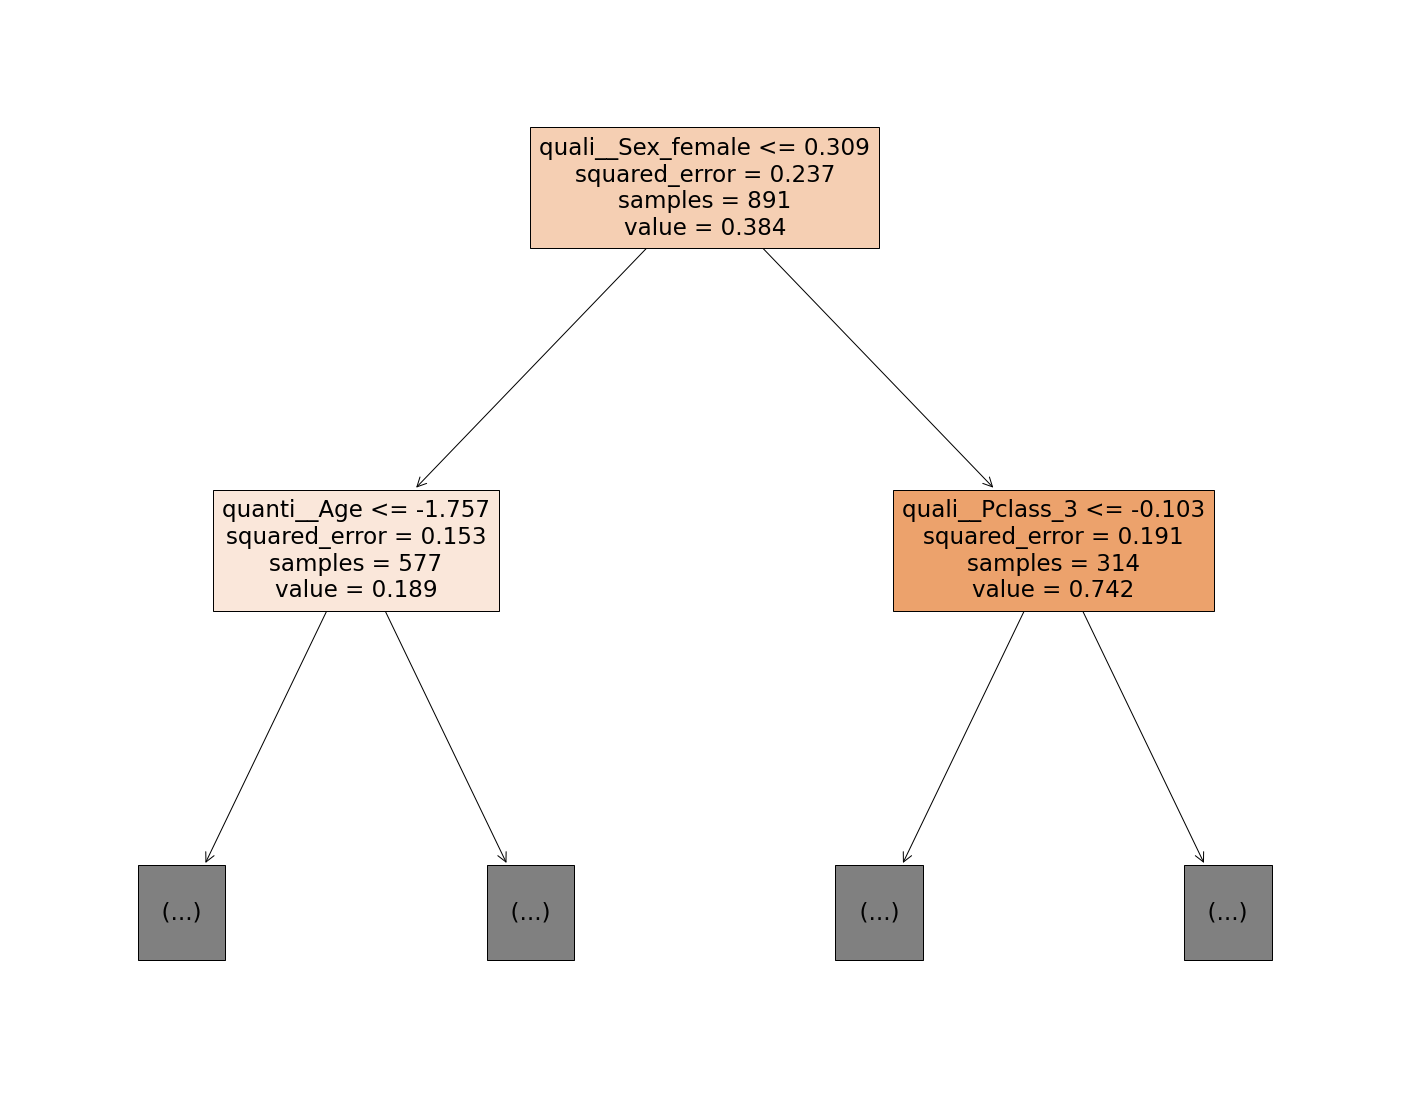

In [ ]:
#Concept
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
tree_reg = DecisionTreeRegressor(random_state=0, min_samples_split = 10) 
tree_reg.fit(x_train, y_train)
# y_train_predictions = tree_reg.predict(x_train)
y_train_predictions = [round(y_hat) for y_hat in tree_reg.predict(x_train)]
printPerformanceMeasures(model= tree_reg, y_true=y_train, y_pred=y_train_predictions)

#PLOTING THE TREE
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(tree_reg, max_depth=1, feature_names=fullPipeline.get_feature_names_out(), 
                    class_names  = 'Survived', filled=True)

#PRINTING FREQUENCY DISTRIBUTIONS
print(y_train.value_counts(normalize = True).reset_index(name='Proportion').rename(columns={'index':'Survived'}))
pd.crosstab(index=train['Sex'], columns=train['Survived'], normalize = "index")#, margins = True
# !pip install dtreeviz
# %pip install -q dtreeviz
# from dtreeviz.trees import dtreeviz # remember to load the package
# import sys
# sys.path.append(f"{os.getcwd()}/../")
# viz = dtreeviz(tree_reg, x_train, y_train.values.ravel(),
#                 target_name="Survived",
#                 feature_names=fullPipeline.get_feature_names_out())
# viz

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor 
forest_reg = RandomForestRegressor(random_state=0, min_samples_split = 10) 
# my_y_train = y_train
# my_y_train.shape = (len(y_train),)
forest_reg.fit(x_train, y_train.values.ravel())
y_train_predictions = [round(y_hat) for y_hat in forest_reg.predict(x_train)]
printPerformanceMeasures(model= forest_reg, y_true=y_train, y_pred=y_train_predictions)

RandomForestRegressor  ACCURACY =  0.9191919191919192
RandomForestRegressor  RMSE =  0.2842676218074806
RandomForestRegressor  MAE =  0.08080808080808081


#### Feature Importance

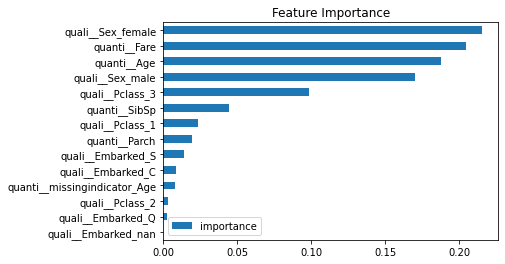

In [ ]:
fi = pd.DataFrame(data=forest_reg.feature_importances_,
             index=fullPipeline.get_feature_names_out(), #xgb_reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

### XGBoost Regression

In [ ]:
# !pip install xgboost
import xgboost as xg
xgb_reg = xg.XGBRegressor(objective ='reg:squarederror', n_estimators = 10, 
                            seed = 0, max_depth = x_train.shape[1])
xgb_reg.fit(x_train, y_train.values.ravel())#, eval_set = [(x_val, y_val)], early_stopping_rounds = 2)
y_train_predictions = [round(y_hat) for y_hat in xgb_reg.predict(x_train)]
printPerformanceMeasures(model= xgb_reg, y_true=y_train, y_pred=y_train_predictions)

XGBRegressor  ACCURACY =  0.9820426487093153
XGBRegressor  RMSE =  0.13400504203456162
XGBRegressor  MAE =  0.017957351290684626


#### Feature Importance

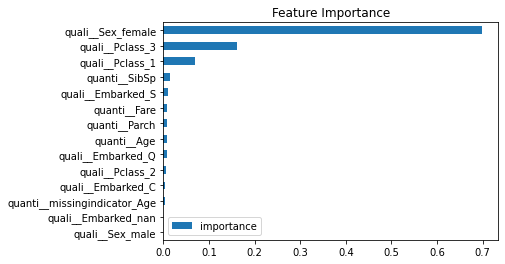

In [ ]:
fi = pd.DataFrame(data=xgb_reg.feature_importances_,
             index=fullPipeline.get_feature_names_out(), #xgb_reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

### Support Vector Regression - SVR

In [ ]:
from sklearn.svm import SVR
svr_reg = SVR(C=1, epsilon=0.01, kernel= 'rbf')
svr_reg.fit(x_train, y_train.values.ravel())
y_train_predictions = [round(y_hat) for y_hat in svr_reg.predict(x_train)]
printPerformanceMeasures(model= svr_reg, y_true=y_train, y_pred=y_train_predictions)

SVR  ACCURACY =  0.8395061728395061
SVR  RMSE =  0.40061680838488767
SVR  MAE =  0.16049382716049382


### Artificial Neural Network - ANN

In [ ]:
#https://towardsdatascience.com/deep-neural-multilayer-perceptron-mlp-with-scikit-learn-2698e77155e
from sklearn.neural_network import MLPRegressor
ann_reg = MLPRegressor(random_state=0, hidden_layer_sizes=(100, 50, 30, 20, 10, 5), 
                       activation="relu", max_iter=2000)
ann_reg.fit(x_train, y_train.values.ravel())
y_train_predictions = [round(y_hat) for y_hat in ann_reg.predict(x_train)]
printPerformanceMeasures(model= ann_reg, y_true=y_train, y_pred=y_train_predictions)

MLPRegressor  ACCURACY =  0.8843995510662177
MLPRegressor  RMSE =  0.34000066019609765
MLPRegressor  MAE =  0.11560044893378227


#### Keras-TensorFlow ANN

In [ ]:
#https://www.tensorflow.org/install
# Requires the latest pip
# !-m pip install --upgrade pip
# Current stable release for CPU and GPU
# !pip install tensorflow
#Testing if tensorflow is installed
import tensorflow as tf 
from tensorflow import keras 
print('tf.__version__: ', tf.__version__)
print('__version__: ', keras.__version__)
print('x_train.shape: ', x_train.shape)

tf.__version__:  2.10.0
__version__:  2.10.0
x_train.shape:  (891, 14)


In [ ]:
#Model Architecture Compilation
def getCompiledTfAnnModel(nHiddenLayers = 0, nNeurons = 0, learningRate = 3e-3, dropoutRate = .2):
    #Model architecture
    tfAnn_reg = keras.models.Sequential(name="MLP_TF_ANN")
    tfAnn_reg.add(keras.layers.InputLayer (name = "input_layer", input_shape =(x_train.shape[1],)))#input layer
    tfAnn_reg.add(keras.layers.Dropout(dropoutRate))#dropout
    # tfAnn_reg.add(keras.layers.Dense(name = "input_and_1st_hidden_layer", units = nNeurons, input_shape =(x_train.shape[1],), activation='relu'))#input layer shape and first hidden layer
    for i in range(1, nHiddenLayers+1):
        tfAnn_reg.add(keras.layers.Dense(name = ("hidden_layer_" + str(i)), units = nNeurons, activation='relu')) # hidden layer # i
        tfAnn_reg.add(keras.layers.Dropout(dropoutRate))
    tfAnn_reg.add(keras.layers.Dense(name = "output_layer", units = 1, activation='linear'))#output layer
    optimizer = keras.optimizers.SGD(learning_rate = learningRate) 
    tfAnn_reg.compile(loss = 'mse', optimizer = optimizer, metrics = 'mae')
    return (tfAnn_reg)

tfAnn_reg = getCompiledTfAnnModel(nHiddenLayers = 1, nNeurons = 10, 
                                    learningRate = 1e-3, dropoutRate = .0)
print(tfAnn_reg.summary())

#Fiting
early_stopping_cb = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 20, restore_best_weights = True)
history = tfAnn_reg.fit(x_train, y_train, epochs=150, batch_size=10, validation_split=.2,
                        verbose=False, callbacks =[early_stopping_cb])

#evaluation
y_train_predictions = [round(y_hat[0]) for y_hat in tfAnn_reg.predict(x_train)]
printPerformanceMeasures(model=tfAnn_reg, y_true=y_train, y_pred=y_train_predictions)

Model: "MLP_TF_ANN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 14)                0         
                                                                 
 hidden_layer_1 (Dense)      (None, 10)                150       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 output_layer (Dense)        (None, 1)                 11        
                                                                 
Total params: 161
Trainable params: 161
Non-trainable params: 0
_________________________________________________________________
None
28/28 [==============================] - 0s 835us/step
Sequential  ACCURACY =  0.8294051627384961
Sequential  RMSE =  0.41303127879314894
Sequential  MAE =  0.17059483726150393


## K-fold Cross-Validation

In [ ]:
#https://scikit-learn.org/stable/modules/cross_validation.html
# from tabnanny import verbose
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
# from sklearn.model_selection import ShuffleSplit #For using the same folds among formalisms
# cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
models_label = []
models_accuracy = []
models_mean_rmse = []
models_std_rmse = []
def computeAccuracyAndRmseScores(models): 
    for model in models:
        mse_scores = - cross_val_score(model, x_train, y_train.values.ravel(), 
                                        scoring ="neg_mean_squared_error", cv = 3, 
                                        verbose = 0, n_jobs=3)#cv) 
        rmse_scores = np.sqrt(mse_scores)
        formalism = type(model).__name__
        models_label.append(formalism)
        y_pred = []
        try:
            y_pred = [round(y_hat) for y_hat in model.predict(x_train)]
        except:
            y_pred = [round(y_hat[0]) for y_hat in model.predict(x_train)]
        models_accuracy.append(accuracy_score(y_true = y_train.values.ravel(), y_pred= y_pred))
        models_mean_rmse.append(rmse_scores.mean())
        models_std_rmse.append(rmse_scores.std())
        print(formalism, " ok ")
    df = pd.DataFrame({'model': models_label, 
                       'train_accuracy': models_accuracy, 
                       'cv_rmse_mean': models_mean_rmse, 
                       'cv_rmse_std': models_std_rmse})
    print(" *********** Rank via train set-based Accuracy and RMSE-based Cross-validation *********** ") 
    print(df.sort_values(by="train_accuracy", ascending = False))
    # print(" RMSE Mean:", rmse_scores.mean()) 
    # print(" RMSE Standard deviation:", rmse_scores.std())
    

In [ ]:
tfAnn_reg = keras.wrappers.scikit_learn.KerasRegressor(getCompiledTfAnnModel)#to behave similarly to a Scikit-Learn regressor
tfAnn_reg.fit(x_train, y_train, epochs=150, batch_size=10, validation_split=.2,
                        verbose=False, callbacks =[early_stopping_cb])
single_models = [lin_reg, log_reg, tree_reg, forest_reg, xgb_reg, svr_reg, ann_reg, tfAnn_reg]
computeAccuracyAndRmseScores(single_models)

C:\Users\praf6\AppData\Local\Temp\ipykernel_21048\3690694718.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  tfAnn_reg = keras.wrappers.scikit_learn.KerasRegressor(getCompiledTfAnnModel)#to behave similarly to a Scikit-Learn regressor


LinearRegression  ok 
LogisticRegression  ok 
DecisionTreeRegressor  ok 
RandomForestRegressor  ok 
XGBRegressor  ok 
SVR  ok 
MLPRegressor  ok 
28/28 [==============================] - 0s 607us/step
KerasRegressor  ok 
 *********** Rank via train set-based Accuracy and RMSE-based Cross-validation *********** 
                   model  train_accuracy  cv_rmse_mean  cv_rmse_std
4           XGBRegressor        0.982043      0.413846     0.014167
2  DecisionTreeRegressor        0.921437      0.430715     0.017108
3  RandomForestRegressor        0.919192      0.369803     0.018079
6           MLPRegressor        0.884400      0.413378     0.023141
5                    SVR        0.839506      0.398729     0.015280
0       LinearRegression        0.802469      0.383768     0.008802
1     LogisticRegression        0.797980      0.459175     0.012555
7         KerasRegressor        0.794613      1.430171     0.142671


## Kaggle Competition Submission File

In [ ]:
test = pd.read_csv(ROOT+'test.csv')
print(test.head())
x_test = fullPipeline.fit_transform(test)
print(x_test)

def saveKaggleSubmissionFile(models):
    index = 0
    for model in models:
        y_pred = []
        try:
            y_pred = [round(y_hat) for y_hat in model.predict(x_test)]
        except:
            try:
                y_pred = [round(y_hat[0]) for y_hat in model.predict(x_test)]
            except:
                for index, row in test.iterrows(): 
                    y_pred.append(round(bbnPredict(row)))

        reg_submission = pd.DataFrame({'PassengerId':test['PassengerId'], 'Survived':y_pred})
        #    reg_submission.head()
        filePath = ROOT + type(model).__name__ + '_' + str(index) +'_submission.csv'
        index += 1
        reg_submission.to_csv(filePath, index=False)
#saveKaggleSubmissionFile([bbn_reg] + single_models)

   PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S  
[[-0.49741333  0.38623105 -0.4002477  ... -0.56814154  2.84375747
  -1.35067551]
 [-0.51227801  1.37137004 -0.4002477  ... -0.56814154 -0.35164743
   0.74037028]
 [-0.46410047  

In [ ]:
#My relative rank in the competiion
print('My current relative rank in the competiion: top ', 100*round(3331/14637, 2), '%')

My current relative rank in the competiion: top  23.0 %


## Optimizing (Fine-Tuning) Your Model
- Grid Search Cross Validation
- Randomized Search Cross Validation, and 
- BayesSearch  Cross Validation

In [ ]:
# probabilistic optimization via BayesSearchCV
#https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f
# !pip install scikit-optimize
from skopt import BayesSearchCV
from skopt.plots import plot_objective
from skopt.space import Real, Categorical, Integer
def getOptimalModelViaBayesSearchCv(modelObj, parsDists, x_train, y_train, verbose=False, 
                                    epochs=150, batch_size=32,validation_split=.2, callbacks=[]):
    # log-uniform: understand as search over p = exp(x) by varying x
    opt = BayesSearchCV(modelObj, parsDists, n_iter=32,  cv=3, return_train_score = True, 
                        scoring = 'neg_mean_squared_error', verbose=verbose, n_jobs = 3)
    if(type(modelObj).__name__!='KerasRegressor'):
        opt.fit(X = x_train, y = y_train.values.ravel())
    else:
        opt.fit(X = x_train, y = y_train, #.values.ravel(), 
                epochs=epochs, batch_size=batch_size,
                validation_split=validation_split, callbacks = callbacks)
    parNames = [name for name, value in parsDists.items()]
    _ = plot_objective(opt.optimizer_results_[0],
                    dimensions=parNames,
                    n_minimum_search=int(1e8))
    plt.show()
    print('best_params = ', opt.best_params_)
    print('best_score (RMSE)= ', np.sqrt(-opt.best_score_))
    model = opt.best_estimator_
    return (model)

### Decision Tree via BayesSearchCV

In [ ]:
computeAccuracyAndRmseScores([tree_reg])

DecisionTreeRegressor  ok 
 *********** Rank via train set-based Accuracy and RMSE-based Cross-validation *********** 
                   model  train_accuracy  cv_rmse_mean  cv_rmse_std
4           XGBRegressor        0.982043      0.413846     0.014167
2  DecisionTreeRegressor        0.921437      0.430715     0.017108
8  DecisionTreeRegressor        0.921437      0.430715     0.017108
3  RandomForestRegressor        0.919192      0.369803     0.018079
6           MLPRegressor        0.884400      0.413378     0.023141
5                    SVR        0.839506      0.398729     0.015280
0       LinearRegression        0.802469      0.383768     0.008802
1     LogisticRegression        0.797980      0.459175     0.012555
7         KerasRegressor        0.794613      1.430171     0.142671


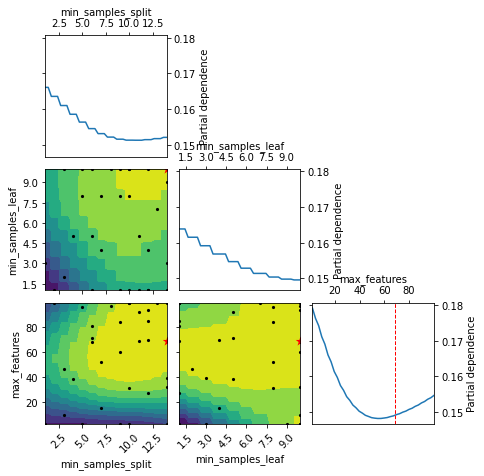

best_params =  OrderedDict([('max_features', 14), ('min_samples_leaf', 10), ('min_samples_split', 69)])
best_score (RMSE)=  0.3787278555001518
DecisionTreeRegressor  ok 
 *********** Rank via train set-based Accuracy and RMSE-based Cross-validation *********** 
                   model  train_accuracy  cv_rmse_mean  cv_rmse_std
4           XGBRegressor        0.982043      0.413846     0.014167
2  DecisionTreeRegressor        0.921437      0.430715     0.017108
8  DecisionTreeRegressor        0.921437      0.430715     0.017108
3  RandomForestRegressor        0.919192      0.369803     0.018079
6           MLPRegressor        0.884400      0.413378     0.023141
5                    SVR        0.839506      0.398729     0.015280
9  DecisionTreeRegressor        0.831650      0.378517     0.012641
0       LinearRegression        0.802469      0.383768     0.008802
1     LogisticRegression        0.797980      0.459175     0.012555
7         KerasRegressor        0.794613      1.430171    

In [ ]:
from sklearn.tree import DecisionTreeRegressor
parsDists = {#'splitter': ["best", "random"],  # categorical parameter
             #'max_depth': (1, x_train.shape[1]),  # integer valued parameter
             'min_samples_split': (2, 100),
             'min_samples_leaf': (1, 10),
             'max_features': (1, x_train.shape[1])#,
             # log-uniform: understand as search over p = exp(x) by varying x
             #'ccp_alpha': (1e-10, 1e+1, 'log-uniform')
             }
tree_reg2 = getOptimalModelViaBayesSearchCv(DecisionTreeRegressor(random_state=0),
                                            parsDists, x_train, y_train)
computeAccuracyAndRmseScores([tree_reg2])


### Logistic Regression via RandomizedSearchCV

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV 
from scipy.stats import uniform
distributions = dict(C=uniform(loc=0, scale=4), penalty=['l2', 'l1'])
log_reg2 = LogisticRegression(solver='saga', random_state=0, max_iter=1000) 
search = RandomizedSearchCV(log_reg2, distributions, random_state=0, n_iter = 10, 
                            verbose=True, cv=3, scoring = 'neg_mean_squared_error')
search.fit(x_train, y_train.values.ravel())
print('best_params= ', search.best_params_)
print('best_score = ', -search.best_score_)
log_reg2 = search.best_estimator_#taking the best model
computeAccuracyAndRmseScores([log_reg2])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
best_params=  {'C': 3.2486749151019727, 'penalty': 'l2'}
best_score =  0.20875420875420878
LogisticRegression  ok 
 *********** Rank via train set-based Accuracy and RMSE-based Cross-validation *********** 
                    model  train_accuracy  cv_rmse_mean  cv_rmse_std
4            XGBRegressor        0.982043      0.413846     0.014167
2   DecisionTreeRegressor        0.921437      0.430715     0.017108
8   DecisionTreeRegressor        0.921437      0.430715     0.017108
3   RandomForestRegressor        0.919192      0.369803     0.018079
6            MLPRegressor        0.884400      0.413378     0.023141
5                     SVR        0.839506      0.398729     0.015280
9   DecisionTreeRegressor        0.831650      0.378517     0.012641
0        LinearRegression        0.802469      0.383768     0.008802
1      LogisticRegression        0.797980      0.459175     0.012555
10     LogisticRegression        0.797980 

### Random Forest via GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV 
randomForestParamsGrid = {'n_estimators': [40, 50, 100], 'max_depth': [None, 5, x_train.shape[1]], 
              'max_features': [6, 8, x_train.shape[1]], 'min_samples_split': [2, 10, 12]}
forest_reg2 = RandomForestRegressor(random_state=0, bootstrap= False) 
grid_search = GridSearchCV(forest_reg2, randomForestParamsGrid, cv = 3, scoring = 'neg_mean_squared_error', 
                           return_train_score = True, verbose=True) 
grid_search.fit(x_train, y_train.values.ravel())
print('best_params= ', grid_search.best_params_)
print('best_score = ', -grid_search.best_score_)
forest_reg2 = grid_search.best_estimator_
computeAccuracyAndRmseScores([forest_reg2])

Fitting 3 folds for each of 81 candidates, totalling 243 fits
best_params=  {'max_depth': 5, 'max_features': 8, 'min_samples_split': 10, 'n_estimators': 40}
best_score =  0.12954833496037846
RandomForestRegressor  ok 
 *********** Rank via train set-based Accuracy and RMSE-based Cross-validation *********** 
                    model  train_accuracy  cv_rmse_mean  cv_rmse_std
4            XGBRegressor        0.982043      0.413846     0.014167
2   DecisionTreeRegressor        0.921437      0.430715     0.017108
8   DecisionTreeRegressor        0.921437      0.430715     0.017108
3   RandomForestRegressor        0.919192      0.369803     0.018079
6            MLPRegressor        0.884400      0.413378     0.023141
11  RandomForestRegressor        0.854097      0.359549     0.016512
5                     SVR        0.839506      0.398729     0.015280
9   DecisionTreeRegressor        0.831650      0.378517     0.012641
0        LinearRegression        0.802469      0.383768     0.008802


### Random Forest via BayesSearchCV

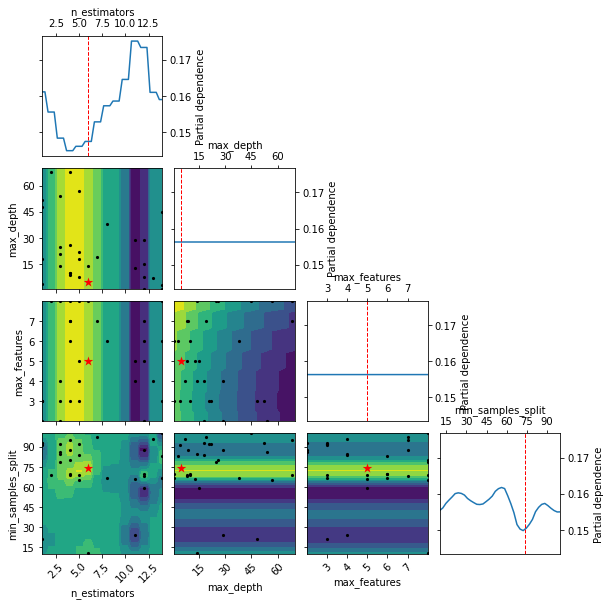

best_params =  OrderedDict([('max_depth', 6), ('max_features', 5), ('min_samples_split', 5), ('n_estimators', 74)])
best_score (RMSE)=  0.3604292286861838
RandomForestRegressor  ok 
 *********** Rank via train set-based Accuracy and RMSE-based Cross-validation *********** 
                    model  train_accuracy  cv_rmse_mean  cv_rmse_std
4            XGBRegressor        0.982043      0.413846     0.014167
2   DecisionTreeRegressor        0.921437      0.430715     0.017108
8   DecisionTreeRegressor        0.921437      0.430715     0.017108
3   RandomForestRegressor        0.919192      0.369803     0.018079
6            MLPRegressor        0.884400      0.413378     0.023141
12  RandomForestRegressor        0.866442      0.360078     0.015906
11  RandomForestRegressor        0.854097      0.359549     0.016512
5                     SVR        0.839506      0.398729     0.015280
9   DecisionTreeRegressor        0.831650      0.378517     0.012641
0        LinearRegression        0.8

In [ ]:
forest_reg3 = RandomForestRegressor(random_state=0, bootstrap=False) 
parsDists = {'n_estimators': Integer(10, 100, 'uniform'), 
             'max_depth': Integer(1, x_train.shape[1], 'uniform'), 
              'max_features': Integer(1, 5*x_train.shape[1], 'uniform'), 
              'min_samples_split': Integer(2, int(.01*len(x_train)), 'uniform')}
forest_reg3 = getOptimalModelViaBayesSearchCv(forest_reg3, parsDists, x_train, y_train)
computeAccuracyAndRmseScores([forest_reg3])

### SVR via BayesSearchCV

[LibSVM]

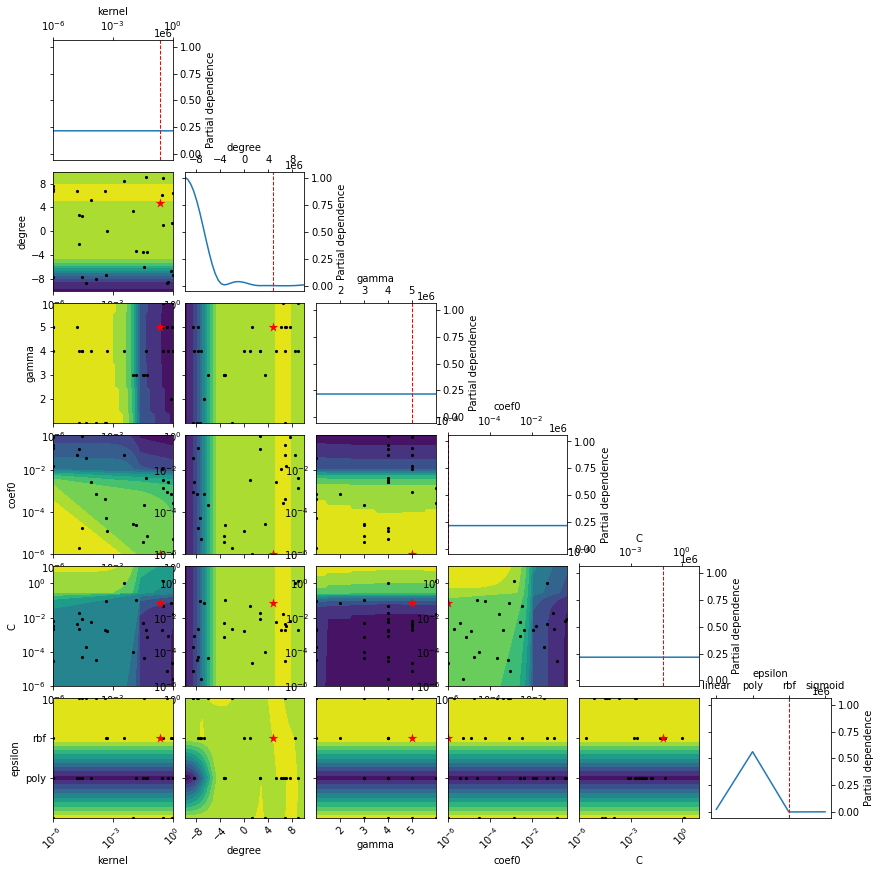

best_params =  OrderedDict([('C', 0.2472184451642832), ('coef0', 4.715732569526423), ('degree', 5), ('epsilon', 1e-06), ('gamma', 0.0753984320211083), ('kernel', 'rbf')])
best_score (RMSE)=  0.3955763542283303
SVR  ok 
 *********** Rank via train set-based Accuracy and RMSE-based Cross-validation *********** 
                    model  train_accuracy  cv_rmse_mean  cv_rmse_std
4            XGBRegressor        0.982043      0.413846     0.014167
2   DecisionTreeRegressor        0.921437      0.430715     0.017108
8   DecisionTreeRegressor        0.921437      0.430715     0.017108
3   RandomForestRegressor        0.919192      0.369803     0.018079
6            MLPRegressor        0.884400      0.413378     0.023141
12  RandomForestRegressor        0.866442      0.360078     0.015906
11  RandomForestRegressor        0.854097      0.359549     0.016512
5                     SVR        0.839506      0.398729     0.015280
9   DecisionTreeRegressor        0.831650      0.378517     0.012641

In [ ]:
# bugged
svr_reg2 = getOptimalModelViaBayesSearchCv(
        SVR(verbose=True),
        {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # categorical parameter,
        'degree': Integer(1, 6),  # integer valued parameter
        'gamma': Real(1e-6, 1e+1, 'log-uniform'), 
        'coef0': Real(-10, 10, 'uniform'), 
        'C': Real(1e-6, 1, 'log-uniform'), 
        'epsilon': Real(1e-6, .5, 'log-uniform')
        }, x_train, y_train, verbose = False)
computeAccuracyAndRmseScores([svr_reg2])

### XGBoost via GridSearchCV

In [ ]:
computeAccuracyAndRmseScores([xgb_reg])

XGBRegressor  ok 
 *********** Rank via train set-based Accuracy and RMSE-based Cross-validation *********** 
                    model  train_accuracy  cv_rmse_mean  cv_rmse_std
4            XGBRegressor        0.982043      0.413846     0.014167
14           XGBRegressor        0.982043      0.413846     0.014167
2   DecisionTreeRegressor        0.921437      0.430715     0.017108
8   DecisionTreeRegressor        0.921437      0.430715     0.017108
3   RandomForestRegressor        0.919192      0.369803     0.018079
6            MLPRegressor        0.884400      0.413378     0.023141
12  RandomForestRegressor        0.866442      0.360078     0.015906
11  RandomForestRegressor        0.854097      0.359549     0.016512
5                     SVR        0.839506      0.398729     0.015280
9   DecisionTreeRegressor        0.831650      0.378517     0.012641
13                    SVR        0.823793      0.395573     0.001647
0        LinearRegression        0.802469      0.383768     0.

In [ ]:
import xgboost as xg
from sklearn.model_selection import GridSearchCV 
XGBParamsGrid = {'n_estimators':[5, 10, 20], 
                 'max_depth': [4, 10, x_train.shape[1]]#, 
                 #'eta': [.01, .1, .3], 
                 #'colsample_bytree': [.2, .5, 1]
                 }
XGB_reg2 = xg.XGBRegressor() 
XGB_grid_search = GridSearchCV(XGB_reg2, XGBParamsGrid, cv = 3, return_train_score = True, 
                               verbose=True, scoring = 'neg_mean_squared_error') 
XGB_grid_search.fit(x_train, y_train.values.ravel())
print('best_params= ', XGB_grid_search.best_params_)
print('best_score = ', -XGB_grid_search.best_score_)
XGB_reg2 = XGB_grid_search.best_estimator_
computeAccuracyAndRmseScores([XGB_reg2])

Fitting 3 folds for each of 9 candidates, totalling 27 fits
best_params=  {'max_depth': 4, 'n_estimators': 10}
best_score =  0.1341763122855166
XGBRegressor  ok 
 *********** Rank via train set-based Accuracy and RMSE-based Cross-validation *********** 
                    model  train_accuracy  cv_rmse_mean  cv_rmse_std
4            XGBRegressor        0.982043      0.413846     0.014167
14           XGBRegressor        0.982043      0.413846     0.014167
2   DecisionTreeRegressor        0.921437      0.430715     0.017108
8   DecisionTreeRegressor        0.921437      0.430715     0.017108
3   RandomForestRegressor        0.919192      0.369803     0.018079
6            MLPRegressor        0.884400      0.413378     0.023141
15           XGBRegressor        0.867565      0.365944     0.016159
12  RandomForestRegressor        0.866442      0.360078     0.015906
11  RandomForestRegressor        0.854097      0.359549     0.016512
5                     SVR        0.839506      0.398729 

### XGBoost via BayesSearchCV

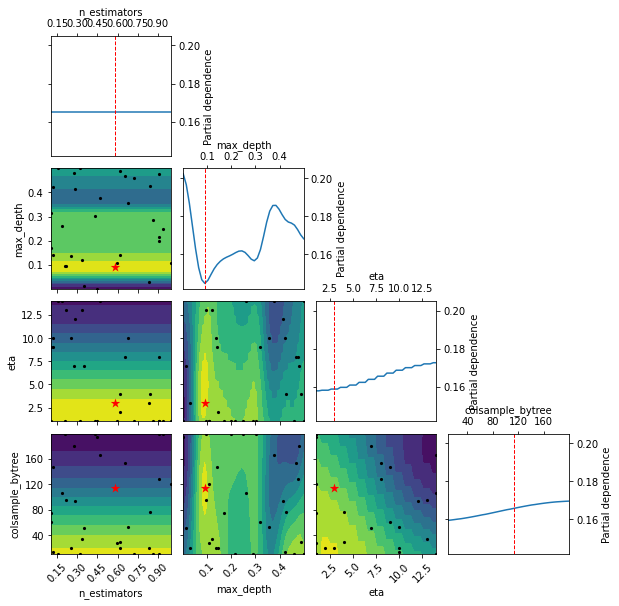

best_params =  OrderedDict([('colsample_bytree', 0.5783246057121986), ('eta', 0.08956175129038432), ('max_depth', 3), ('n_estimators', 114)])
best_score (RMSE)=  0.3654687868846633
XGBRegressor  ok 
 *********** Rank via train set-based Accuracy and RMSE-based Cross-validation *********** 
                    model  train_accuracy  cv_rmse_mean  cv_rmse_std
4            XGBRegressor        0.982043      0.413846     0.014167
14           XGBRegressor        0.982043      0.413846     0.014167
8   DecisionTreeRegressor        0.921437      0.430715     0.017108
2   DecisionTreeRegressor        0.921437      0.430715     0.017108
3   RandomForestRegressor        0.919192      0.369803     0.018079
6            MLPRegressor        0.884400      0.413378     0.023141
16           XGBRegressor        0.872054      0.365154     0.015161
15           XGBRegressor        0.867565      0.365944     0.016159
12  RandomForestRegressor        0.866442      0.360078     0.015906
11  RandomForestReg

In [ ]:
import xgboost as xg
xgb_reg3 = getOptimalModelViaBayesSearchCv(modelObj=xg.XGBRegressor(),
                                        parsDists={
                                            'n_estimators': Integer(10, 200, 'uniform'), 
                                            'max_depth': Integer(1, x_train.shape[1], 'uniform'), 
                                            'eta': Real(.001, .5, 'uniform'), 
                                            'colsample_bytree': Real(.1, 1, 'uniform')}, 
                                            x_train=x_train, y_train=y_train)
computeAccuracyAndRmseScores([xgb_reg3])

### Keras-TensorFlow ANN via BayesSearchCV

C:\Users\praf6\AppData\Local\Temp\ipykernel_21048\3367373200.py:7: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  modelObj=keras.wrappers.scikit_learn.KerasRegressor(getCompiledTfAnnModel),


Epoch 1/150
23/23 [==============================] - 0s 6ms/step - loss: 1.3834 - mae: 0.8843 - val_loss: 1.2984 - val_mae: 0.7997
Epoch 2/150
23/23 [==============================] - 0s 2ms/step - loss: 0.9746 - mae: 0.7311 - val_loss: 0.9272 - val_mae: 0.6867
Epoch 3/150
23/23 [==============================] - 0s 2ms/step - loss: 0.7203 - mae: 0.6426 - val_loss: 0.6843 - val_mae: 0.5965
Epoch 4/150
23/23 [==============================] - 0s 2ms/step - loss: 0.5235 - mae: 0.5484 - val_loss: 0.5320 - val_mae: 0.5286
Epoch 5/150
23/23 [==============================] - 0s 3ms/step - loss: 0.4389 - mae: 0.5014 - val_loss: 0.4154 - val_mae: 0.4691
Epoch 6/150
23/23 [==============================] - 0s 2ms/step - loss: 0.3478 - mae: 0.4506 - val_loss: 0.3476 - val_mae: 0.4306
Epoch 7/150
23/23 [==============================] - 0s 2ms/step - loss: 0.3126 - mae: 0.4266 - val_loss: 0.2933 - val_mae: 0.3973
Epoch 8/150
23/23 [==============================] - 0s 2ms/step - loss: 0.2714 - m

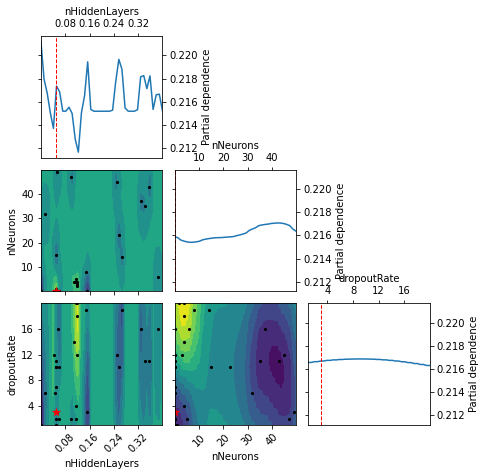

best_params =  OrderedDict([('dropoutRate', 0.048742118600102205), ('nHiddenLayers', 0), ('nNeurons', 3)])
best_score (RMSE)=  0.38574199005645426


In [ ]:
import tensorflow as tf
from tensorflow import keras
early_stopping_cb = keras.callbacks.EarlyStopping(
                        monitor='val_loss', patience=5, restore_best_weights=True)
tfAnn_reg2 = getOptimalModelViaBayesSearchCv(
    # to behave similarly to a Scikit-Learn regressor
    modelObj=keras.wrappers.scikit_learn.KerasRegressor(getCompiledTfAnnModel),
    parsDists={
        'nHiddenLayers': Integer(0, 50, 'uniform'),
        'nNeurons': Integer(1, 20, 'uniform'),
        #'learningRate': Real(1e-3, .2, 'uniform'),
        'dropoutRate': Real(0, .4, 'uniform')},
    x_train=x_train, y_train=y_train,
    epochs=150, batch_size=32, validation_split=.2, callbacks=[early_stopping_cb])


In [ ]:
computeAccuracyAndRmseScores([tfAnn_reg2])

28/28 [==============================] - 0s 579us/step
KerasRegressor  ok 
 *********** Rank via train set-based Accuracy and RMSE-based Cross-validation *********** 
                    model  train_accuracy  cv_rmse_mean  cv_rmse_std
4            XGBRegressor        0.982043      0.413846     0.014167
14           XGBRegressor        0.982043      0.413846     0.014167
2   DecisionTreeRegressor        0.921437      0.430715     0.017108
8   DecisionTreeRegressor        0.921437      0.430715     0.017108
3   RandomForestRegressor        0.919192      0.369803     0.018079
6            MLPRegressor        0.884400      0.413378     0.023141
16           XGBRegressor        0.872054      0.365154     0.015161
15           XGBRegressor        0.867565      0.365944     0.016159
12  RandomForestRegressor        0.866442      0.360078     0.015906
11  RandomForestRegressor        0.854097      0.359549     0.016512
5                     SVR        0.839506      0.398729     0.015280
9   D

In [ ]:
optModels = [tree_reg2, log_reg2, forest_reg2, 
					forest_reg3, svr_reg2, XGB_reg2, xgb_reg3, tfAnn_reg2]
saveKaggleSubmissionFile(optModels)

14/14 [==============================] - 0s 0s/step


## Stacking
https://scikit-learn.org/stable/auto_examples/ensemble/plot_stack_predictors.html#sphx-glr-auto-examples-ensemble-plot-stack-predictors-py